<b><font color='darkred'>
SVM - Support Vector Machines
-----------------
➔ SVC & SVR mit Hyperparametersuche

- Suche nach der optimaler Subsampling-Länge

In [17]:
import numpy as np
from sklearn import model_selection, svm, metrics
import helper

In [18]:
SCALE = 2000

In [19]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

<b><font color='lightgreen'> Validierungsdaten aus Trainingsdaten definieren

In [20]:
versuche_train_valid, versuche_test_valid = model_selection.train_test_split(versuche_train, test_size=0.1)
versuche_train_valid

,key,nr,label,label_name,festigkeit
72,ok_1638,1638,0,OK-Schweißung,2990.000000
387,near_ok_sonowechsel_2959,2959,1,NEAR-OK-Sonotrodenwechsel,2581.049316
397,fehler_leitungsversatz_2581,2581,3,Leitungsversatz,2584.419434
265,fehler_oel_2050,2050,2,Öl auf Terminalversatz,1180.000000
479,ok_1671,1671,0,OK-Schweißung,2770.000000
...,...,...,...,...,...
268,ok_1698,1698,0,OK-Schweißung,2730.000000
422,fehler_oel_2097,2097,2,Öl auf Terminalversatz,0.000000
380,near_ok_sonowechsel_2996,2996,1,NEAR-OK-Sonotrodenwechsel,2809.430908
300,near_ok_sonowechsel_2987,2987,1,NEAR-OK-Sonotrodenwechsel,2506.806641


<b><font color='lightgreen'> Abtrennen der Zielgrößen: Klasse & Zugfestigkeit

In [21]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

# Validierungsdaten
label_train_valid      = versuche_train_valid.label.values
festigkeit_train_valid = versuche_train_valid.festigkeit.values

label_test_valid      = versuche_test_valid.label.values
festigkeit_test_valid = versuche_test_valid.festigkeit.values

<b><font color='lightgreen'> Modellbewertung

In [22]:
def eval_model(prefix, truth, pred):
    mse = metrics.mean_squared_error(truth, pred)
    mae = metrics.mean_absolute_error(truth, pred)
    print(f"{prefix:<10} MSE: {mse:8.1f} RMSE: {np.sqrt(mse):8.1f} MAE: {mae:8.1f}")
    return mae

<b><font color='lightgreen'> Suche nach optimaler Subsampling-Länge

In [32]:
best_results = []

for subsample_size in range(10, 40, 1):
    print("\nsubsample size:", subsample_size)
    subsample = helper.Subsample(subsample_size, ts_len=None)
    subsample.fit() 

    # Transformation der Trainingsdaten
    tsMaxScale = helper.TsMaxScaler()
    X_train = subsample.transform(versuche_train.key, kurven)
    X_train_scaled = tsMaxScale.fit_transform(X_train)
    X2_train = X_train_scaled[:,:,0]

    # Transformation der Validierungsdaten
    # tsMaxScale = helper.TsMaxScaler()
    X_train_valid = subsample.transform(versuche_train_valid.key, kurven)
    X_train_scaled_valid = tsMaxScale.fit_transform(X_train_valid)
    X2_train_valid = X_train_scaled_valid[:,:,0]

    # Parameter-Raum für RandomizedSearchCV
    params = {
        'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000 (Standard 50 Werte)
        'gamma': np.logspace(-5, 3), # 50 Werte zwischen 1e-5 und 10
        #'kernel': ['rbf', 'linear'],
    }

    # Randomized Search für Hyperparameter
    random_search_svr = model_selection.RandomizedSearchCV(
        svm.SVR(),
        params,
        n_iter=30,
    )
    random_search_svr.fit(X2_train, festigkeit_train)

    # Beste Parameter und Modell
    best_params = random_search_svr.best_params_
    best_estim  = random_search_svr.best_estimator_

    # Performance auf dem Trainingssatz evaluieren
    pred_train = best_estim.predict(X2_train)
    mae = eval_model('Train ', festigkeit_train, pred_train)

    # Performance auf der Validierungsmenge
    pred_val = best_estim.predict(X2_train_valid)
    mae_val = eval_model('Train Valid', festigkeit_train_valid, pred_val)

    # Ergebnisse speichern
    best_results.append({
        'subsample_size': subsample_size,
        'best_params': best_params,
        'validation_mae': mae_val,
        'model': best_estim,
        'mae': mae,
    })

# Bester MAE-Wert und zugehörige Parameter auswählen
best_result = min(best_results, key=lambda x: x['mae'])
print("\nBest overall configuration:")
print(f"Best Subsample size: {best_result['subsample_size']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Trainings  MAE: {best_result['mae']}")
print(f"Validation MAE: {best_result['validation_mae']}")


subsample size: 10
Train      MSE:  17331.6 RMSE:    131.6 MAE:     89.7
Train Valid MSE:  15960.6 RMSE:    126.3 MAE:     87.6

subsample size: 11
Train      MSE:  16898.6 RMSE:    130.0 MAE:     88.8
Train Valid MSE:  15019.1 RMSE:    122.6 MAE:     85.7

subsample size: 12
Train      MSE:  14878.5 RMSE:    122.0 MAE:     82.8
Train Valid MSE:  13198.1 RMSE:    114.9 MAE:     79.6

subsample size: 13
Train      MSE:  18309.2 RMSE:    135.3 MAE:     90.5
Train Valid MSE:  16082.7 RMSE:    126.8 MAE:     86.6

subsample size: 14
Train      MSE:  13431.7 RMSE:    115.9 MAE:     76.6
Train Valid MSE:  12105.9 RMSE:    110.0 MAE:     73.7

subsample size: 15
Train      MSE:  22072.3 RMSE:    148.6 MAE:     99.8
Train Valid MSE:  19626.9 RMSE:    140.1 MAE:     96.6

subsample size: 16
Train      MSE:  17627.3 RMSE:    132.8 MAE:     87.8
Train Valid MSE:  15510.5 RMSE:    124.5 MAE:     84.4

subsample size: 17
Train      MSE:  11538.7 RMSE:    107.4 MAE:     69.1
Train Valid MSE:  10777

<b><font color='lightgreen'> Daten transformieren und skalieren nach bester subsample_size

In [8]:
subsample = helper.Subsample(best_result['subsample_size'], ts_len=None)
subsample.fit()

tsMaxScale = helper.TsMaxScaler()
X_train = subsample.transform(versuche_train.key, kurven)
X_train_scaled = tsMaxScale.fit_transform(X_train)
X2_train = X_train_scaled[:,:,0]

X_test = subsample.transform(versuche_test.key, kurven)
X_test_scaled = tsMaxScale.transform(X_test)
X2_test = X_test_scaled[:,:,0]
X2_train.shape, X2_test.shape

festigkeit_train = festigkeit_train/SCALE
festigkeit_test  = festigkeit_test/SCALE

<b><font color='darkred'> ____________________________________________________________________________________________________________________________________

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

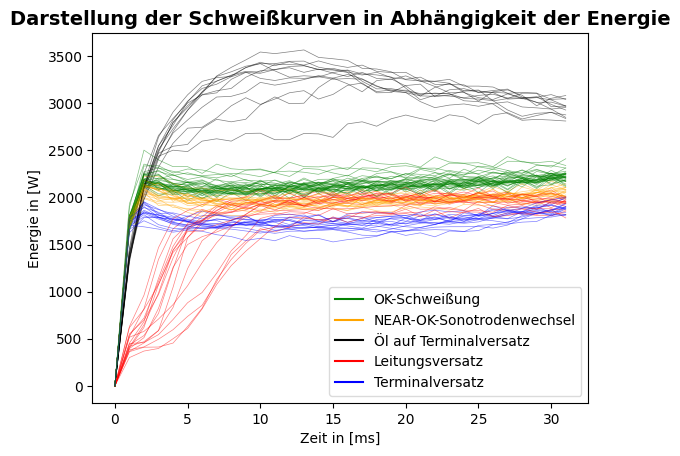

In [9]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
# Komplette Kurve auf 26 (best_result['subsample_size'] Zeitpunkte in gleichem Abstand approximiert

<b><font color='lightgreen'> Kontrollanzeige t-SNE

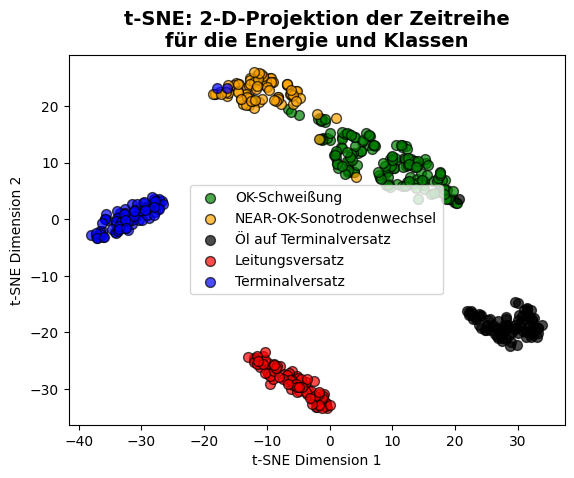

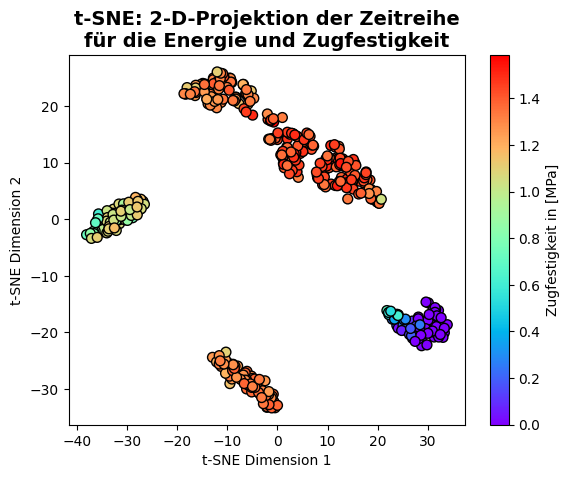

In [10]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Zugfestigkeit')

<b><font color='darkred'>
SVM
-----------------
➔ kann nur 2-dimensionale Daten nutzen, daher Daten "flatten"     
➔ oder alternativ nur power verwenden (hier bessere Ergebnisse)     
  &emsp; <i> versuchsnr + zeitpunkt + power (daher die 0)

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Standardparameter)

In [11]:
modelSVC = svm.SVC(probability=True)
_ = modelSVC.fit(X2_train, label_train)

<b><font color='lightgreen'> Modellbewertung</b>

In [12]:
pred_train = modelSVC.predict(X2_train)
pred_test  = modelSVC.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.977     0.988        43
   near_ok_sonowechsel      0.905     1.000     0.950        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.983       120
             macro avg      0.981     0.987     0.983       120
          weighted avg      0.985     0.983     0.984       120



,Train,Test
Metric,,
Accuracy,0.983,0.983
Precision,0.984,0.985
Recall,0.983,0.983
F1-score,0.983,0.984


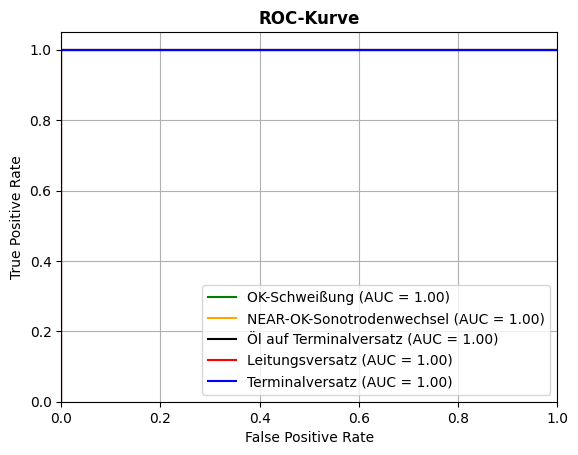

In [13]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

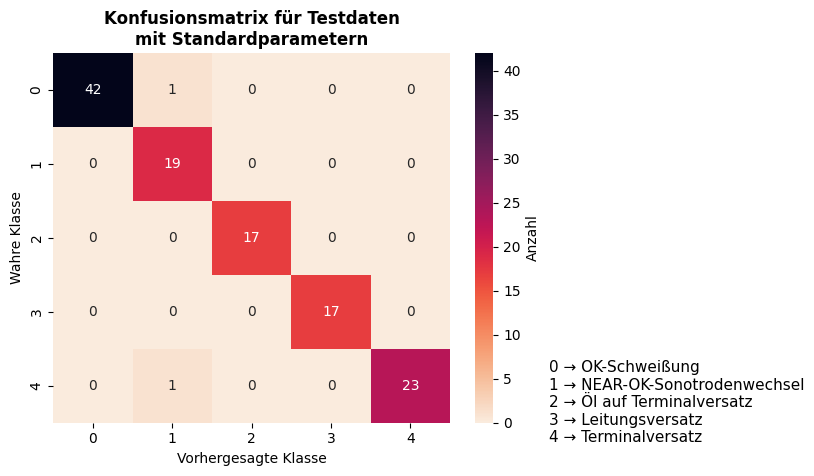

In [14]:
helper.plot_confusion(label_test, pred_test, 'Testdaten\nmit Standardparametern')

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Hyperparametersuche)

In [15]:
params = {
    'C': np.logspace(0, 5),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear']
}
random_search_svc = model_selection.RandomizedSearchCV(
    svm.SVC(probability=True), 
    params, 
    n_iter=30,
)
random_search_svc.fit(X2_train, label_train)
print("Beste Parameter:")
for param, value in random_search_svc.best_params_.items():
    print(f"  {param:6}: {value:8.3f}" if isinstance(value, float) else f"  {param:6}: {value:>8}")

Beste Parameter:
  kernel:   linear
  gamma :    0.000
  C     :  222.300


In [16]:
modelSVC_best = random_search_svc.best_estimator_
modelSVC_best

SVC(C=222.29964825261956, gamma=4.094915062380427e-05, kernel='linear',
    probability=True)

<b><font color='lightgreen'> Modellbewertung</b>

In [17]:
pred_train = modelSVC_best.predict(X2_train)
pred_test  = modelSVC_best.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.977     0.988        43
   near_ok_sonowechsel      0.905     1.000     0.950        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.983       120
             macro avg      0.981     0.987     0.983       120
          weighted avg      0.985     0.983     0.984       120



,Train,Test
Metric,,
Accuracy,0.998,0.983
Precision,0.998,0.985
Recall,0.998,0.983
F1-score,0.998,0.984


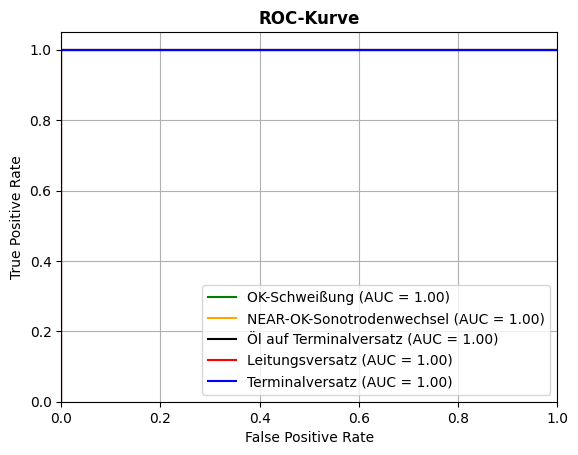

In [18]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC_best.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

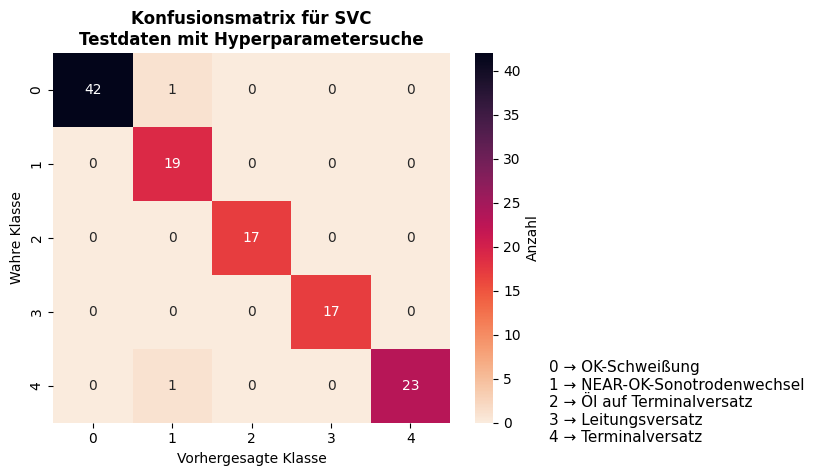

In [19]:
helper.plot_confusion(label_test, pred_test, 'SVC\nTestdaten mit Hyperparametersuche')

<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Standardparameter)

In [20]:
regr = svm.SVR()
regr.fit(X2_train, festigkeit_train)
print("Training abgeschlossen")

y_pred_train = regr.predict(X2_train)
y_pred_test = regr.predict(X2_test)

Training abgeschlossen


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

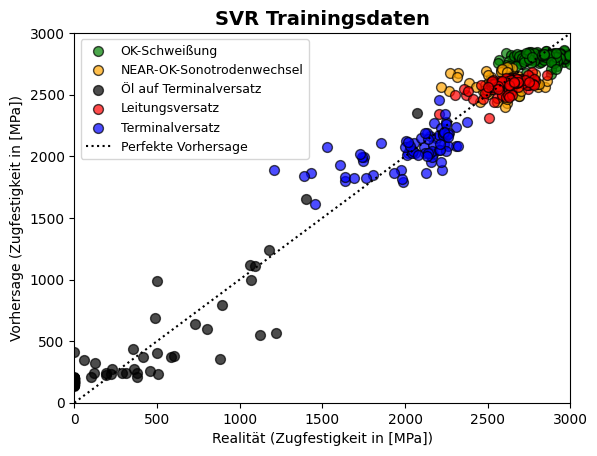

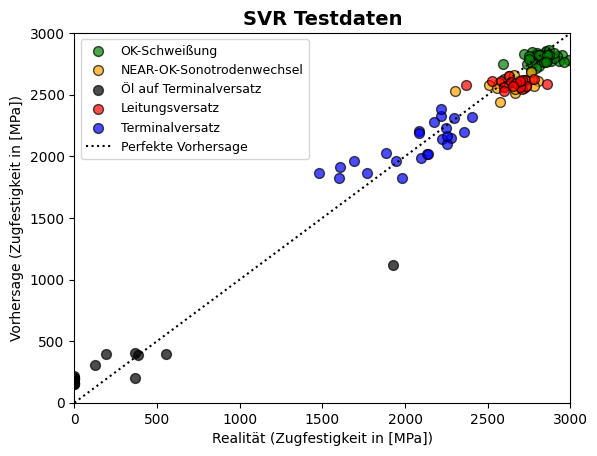

In [21]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [22]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,22457.50,22163.84
RMSE,149.86,148.88
MAE,116.42,112.04
R²,0.98,0.97


<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparameter) </b>

In [23]:
params = {
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear'],
}
estimator = model_selection.RandomizedSearchCV(
    svm.SVR(),  
    params,     
    n_iter=50,
)
estimator.fit(X2_train, festigkeit_train)
estimator_best = estimator.best_estimator_
estimator_best

SVR(C=16.768329368110074, gamma=4.291934260128778)

In [24]:
y_pred_train = estimator_best.predict(X2_train)
y_pred_test = estimator_best.predict(X2_test)

<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

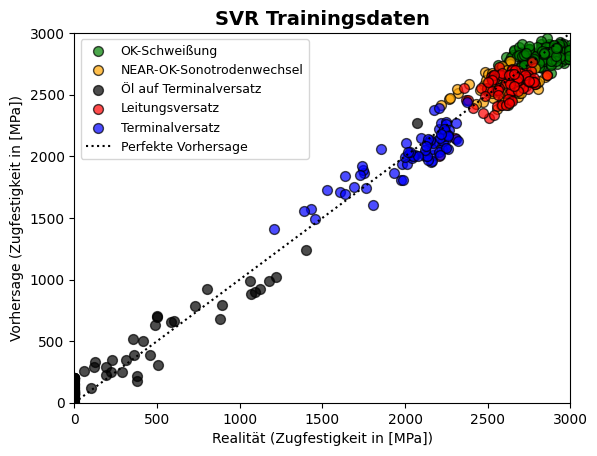

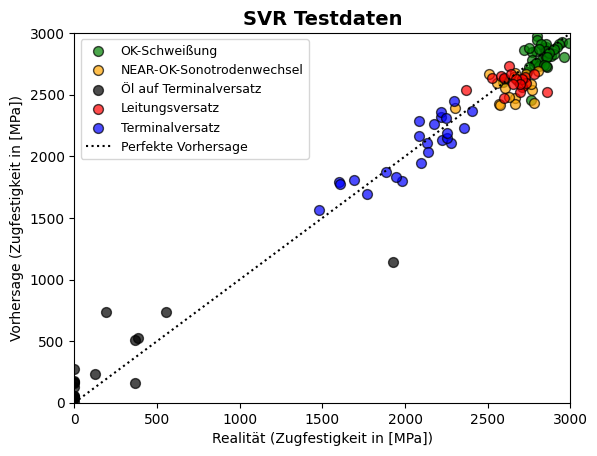

In [25]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [26]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,13581.39,23357.82
RMSE,116.54,152.83
MAE,97.41,112.72
R²,0.98,0.97


<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparameter Subsampling Size) </b>

<b><font color='lightgreen'> Hyperparametersuche bereits in Zeile [7] bei Suche optimaler Subsampling size </b>

In [27]:
regr_best = svm.SVR(gamma=best_result['best_params']['gamma'], C=best_result['best_params']['C'])
_= regr_best.fit(X2_train, festigkeit_train)
regr_best

SVR(C=5689.866029018293, gamma=7.543120063354607)

In [28]:
y_pred_train = regr_best.predict(X2_train)
y_pred_test = regr_best.predict(X2_test)

<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

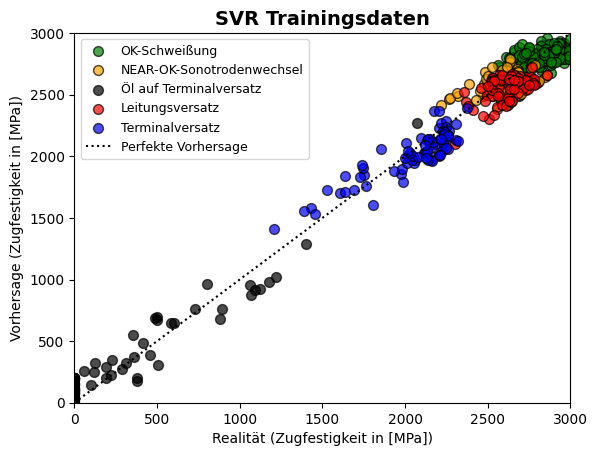

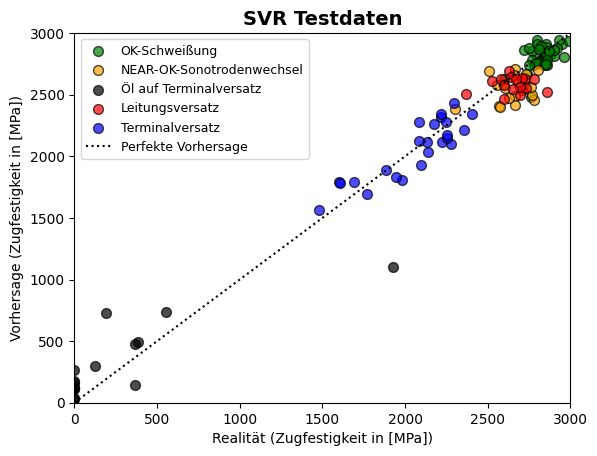

In [29]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [30]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,13912.75,23872.18
RMSE,117.95,154.51
MAE,98.65,112.88
R²,0.98,0.97
